In [1]:
# first change the directory over to ssbd release
import os 
import xml.etree.ElementTree as ET

# The first step is preprocessing. We use the [SSBD Dataset](https://rolandgoecke.net/research/datasets/ssbd/) in order to get the data for hand flapping and spinning. 

## The dataset does contain 75 URLs (although we'll ignore all headbanging videos) to youtube videos. All the data is nicely stored in XML files that I will read to get the youtube videos and also the time stamps of when the beheavior (hand flapping or spinning) occurs. Then I will use pytube to download the youtube videos to .mp4 and moviepy to cut the .mp4 videos into just the areas of interest. 

In [2]:
# next step would be to get the hand flapping and spinning data 

tree = ET.parse("ssbd-release/Annotations/v_ArmFlapping_07.xml")
root = tree.getroot()
for child in root:
    # for each child in the root 
    if child.tag == "url":
        print(child.text)
    if child.tag == "behaviours":
        for behavior in child: # go through each reported behavior 
            for tag in behavior: # tag is just the attribute of the behavior 
                if tag.tag == "time":
                    print(tag.text)
                if tag.tag == "intensity":
                    print(tag.text)
                if tag.tag == "category":
                    print(tag.text)

http://www.youtube.com/watch?v=T9rbit_oiJA
0004:0010
armflapping
high
0015:0020
armflapping
high


In [3]:
def convert_to_second(time : str) -> int:
    # this will take in a time like "0125" or 1:25 and make it 85 (60 + 25)
    overall_seconds = 0 
    for i, time_char in enumerate(reversed(time)):
        if i == 0:
            overall_seconds += int(time_char)
        if i == 1:
            overall_seconds += int(time_char) * 10
        if i == 2:
            overall_seconds += int(time_char) * 60 
        if i == 3:
            overall_seconds += int(time_char) * 600 
    return overall_seconds 

assert convert_to_second('2345') == 23 * 60 + 45  

In [5]:
from collections import defaultdict
URLS_TO_DOWNLOAD = set() # contains all youtube videos to download 
links_to_times = {} # data will be stored here like {link : {'category' : [(start, end)], 'another cat' : [(start, end)]}

for i, file_name in enumerate(os.listdir('ssbd-release/Annotations/')):
    # parse this file 
    tree = ET.parse('ssbd-release/Annotations/' + file_name)
    root = tree.getroot() 
    
    # everything we need to store
    URL = ""
    
    for child in root:
        
        if child.tag == "url":
            URL = child.text # store URL
            URLS_TO_DOWNLOAD.add(URL)
            links_to_times[URL] = defaultdict(list) 
        
        if child.tag == "behaviours": # this child has the list of behaviors 
            for reported_behavior in child: 
                for info in reported_behavior:
                    # gather the start time, end time, and category for this youtube link 
                    if info.tag == "time":
                        # the time will be start:end 
                        times = str(info.text) # contains the string 
                        if times.count(":"): 
                            divider_index = times.index(":")
                        elif times.count("-"):
                            divider_index = times.index("-")
                        else:
                            break # invalid then 
                        START_TIME, END_TIME = convert_to_second(times[:divider_index]), convert_to_second(times[divider_index + 1:])
                        
                    if info.tag == "category":
                        # this is the label 
                        LABEL = info.text 
                
                # create an entry for this reported behavior 
                links_to_times[URL][LABEL].append((START_TIME, END_TIME))

In [6]:
# pickle this just incase 
import pickle 
with open("links_to_times.pkl", 'wb') as f:
    pickle.dump(links_to_times, f)

In [ ]:
from moviepy.video.io.VideoFileClip import VideoFileClip

input_video_path = 'myPath/vid1.mp4'
output_video_path = 'myPath/output/vid1.mp4'

with VideoFileClip(input_video_path) as video:
    new = video.subclip(t1, t2)
    new.write_videofile(output_video_path, audio_codec='aac')

In [13]:
import cv2
import numpy as np
from moviepy.video.io.VideoFileClip import VideoFileClip
from pytube import YouTube # used to download the videos
FPS = 30 
for i, (url, category_times) in enumerate(links_to_times.items()): 
    
    # download the video 
    y = YouTube(url)
    try: 
        y.streams.get_highest_resolution().download() 
    except Exception as e:
        print(f"annoying url: {url}")
        continue 
    for category, times in category_times.items(): 
        if category == "headbanging":
            print("this is headbanging, so skipping")
            continue 
        folder_path = "behavior_data/" + category + "/"
        
        for start_time, end_time in times:
            try:
                input_file = y.streams.get_highest_resolution().default_filename
                output_file = folder_path + f"{i}.mp4"
                with VideoFileClip(input_file) as video:
                    new = video.subclip(start_time, end_time)
                    new.write_videofile(output_file, audio_codec='aac')
            except Exception as e:
                print(f"failed on {i}")
    os.remove(y.streams.get_highest_resolution().default_filename)

Moviepy - Building video behavior_data/spinning/0.mp4.
MoviePy - Writing audio in 0TEMP_MPY_wvf_snd.mp4
MoviePy - Done.
Moviepy - Writing video behavior_data/spinning/0.mp4



Moviepy - Done !
Moviepy - video ready behavior_data/spinning/0.mp4
this is headbanging, so skipping


t:   0%|          | 0/168 [00:00<?, ?it/s, now=None]                

Moviepy - Building video behavior_data/armflapping/2.mp4.
MoviePy - Writing audio in 2TEMP_MPY_wvf_snd.mp4
MoviePy - Done.
Moviepy - Writing video behavior_data/armflapping/2.mp4



Moviepy - Done !
Moviepy - video ready behavior_data/armflapping/2.mp4


t:   0%|          | 0/168 [00:00<?, ?it/s, now=None]                

Moviepy - Building video behavior_data/armflapping/2.mp4.
MoviePy - Writing audio in 2TEMP_MPY_wvf_snd.mp4
MoviePy - Done.
Moviepy - Writing video behavior_data/armflapping/2.mp4



Moviepy - Done !
Moviepy - video ready behavior_data/armflapping/2.mp4


t:   0%|          | 0/180 [00:00<?, ?it/s, now=None]                

Moviepy - Building video behavior_data/armflapping/3.mp4.
MoviePy - Writing audio in 3TEMP_MPY_wvf_snd.mp4
MoviePy - Done.
Moviepy - Writing video behavior_data/armflapping/3.mp4



Moviepy - Done !
Moviepy - video ready behavior_data/armflapping/3.mp4


chunk:  30%|██▉       | 131/442 [00:00<00:00, 1307.88it/s, now=None]

Moviepy - Building video behavior_data/armflapping/4.mp4.
MoviePy - Writing audio in 4TEMP_MPY_wvf_snd.mp4


t:   5%|▌         | 30/600 [00:00<00:01, 291.32it/s, now=None]      

MoviePy - Done.
Moviepy - Writing video behavior_data/armflapping/4.mp4



Moviepy - Done !
Moviepy - video ready behavior_data/armflapping/4.mp4


t:   0%|          | 0/240 [00:00<?, ?it/s, now=None]                

Moviepy - Building video behavior_data/armflapping/4.mp4.
MoviePy - Writing audio in 4TEMP_MPY_wvf_snd.mp4
MoviePy - Done.
Moviepy - Writing video behavior_data/armflapping/4.mp4



Moviepy - Done !
Moviepy - video ready behavior_data/armflapping/4.mp4


t:   0%|          | 0/216 [00:00<?, ?it/s, now=None]                

Moviepy - Building video behavior_data/armflapping/5.mp4.
MoviePy - Writing audio in 5TEMP_MPY_wvf_snd.mp4
MoviePy - Done.
Moviepy - Writing video behavior_data/armflapping/5.mp4



chunk:   0%|          | 0/89 [00:00<?, ?it/s, now=None]        

Moviepy - Done !
Moviepy - video ready behavior_data/armflapping/5.mp4
Moviepy - Building video behavior_data/armflapping/5.mp4.
MoviePy - Writing audio in 5TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video behavior_data/armflapping/5.mp4

Moviepy - Done !
Moviepy - video ready behavior_data/armflapping/5.mp4


t:   0%|          | 0/168 [00:00<?, ?it/s, now=None]                

Moviepy - Building video behavior_data/armflapping/5.mp4.
MoviePy - Writing audio in 5TEMP_MPY_wvf_snd.mp4
MoviePy - Done.
Moviepy - Writing video behavior_data/armflapping/5.mp4



chunk:   0%|          | 0/375 [00:00<?, ?it/s, now=None]       

Moviepy - Done !
Moviepy - video ready behavior_data/armflapping/5.mp4
Moviepy - Building video behavior_data/armflapping/5.mp4.
MoviePy - Writing audio in 5TEMP_MPY_wvf_snd.mp4


t:  25%|██▌       | 104/408 [00:00<00:00, 1038.83it/s, now=None]    

MoviePy - Done.
Moviepy - Writing video behavior_data/armflapping/5.mp4



Moviepy - Done !
Moviepy - video ready behavior_data/armflapping/5.mp4
this is headbanging, so skipping
annoying url: http://www.youtube.com/watch?v=WcsZ9eMQ5Zs
this is headbanging, so skipping


Moviepy - Building video behavior_data/armflapping/9.mp4.
MoviePy - Writing audio in 9TEMP_MPY_wvf_snd.mp4
MoviePy - Done.
Moviepy - Writing video behavior_data/armflapping/9.mp4

Moviepy - Done !
Moviepy - video ready behavior_data/armflapping/9.mp4


Moviepy - Building video behavior_data/armflapping/9.mp4.
MoviePy - Writing audio in 9TEMP_MPY_wvf_snd.mp4
MoviePy - Done.
Moviepy - Writing video behavior_data/armflapping/9.mp4



chunk:   0%|          | 0/45 [00:00<?, ?it/s, now=None]

Moviepy - Done !
Moviepy - video ready behavior_data/armflapping/9.mp4
Moviepy - Building video behavior_data/armflapping/9.mp4.
MoviePy - Writing audio in 9TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video behavior_data/armflapping/9.mp4

Moviepy - Done !
Moviepy - video ready behavior_data/armflapping/9.mp4


chunk:  42%|████▏     | 252/596 [00:00<00:00, 2515.50it/s, now=None]

Moviepy - Building video behavior_data/armflapping/10.mp4.
MoviePy - Writing audio in 10TEMP_MPY_wvf_snd.mp4


t:   8%|▊         | 68/802 [00:00<00:01, 677.18it/s, now=None]      

MoviePy - Done.
Moviepy - Writing video behavior_data/armflapping/10.mp4



chunk:   0%|          | 0/1235 [00:00<?, ?it/s, now=None]      

Moviepy - Done !
Moviepy - video ready behavior_data/armflapping/10.mp4
Moviepy - Building video behavior_data/armflapping/10.mp4.
MoviePy - Writing audio in 10TEMP_MPY_wvf_snd.mp4


t:   4%|▍         | 71/1663 [00:00<00:02, 692.43it/s, now=None]       

MoviePy - Done.
Moviepy - Writing video behavior_data/armflapping/10.mp4



chunk:   0%|          | 0/464 [00:00<?, ?it/s, now=None]         

Moviepy - Done !
Moviepy - video ready behavior_data/armflapping/10.mp4
Moviepy - Building video behavior_data/armflapping/10.mp4.
MoviePy - Writing audio in 10TEMP_MPY_wvf_snd.mp4


t:  12%|█▏        | 72/624 [00:00<00:00, 704.25it/s, now=None]      

MoviePy - Done.
Moviepy - Writing video behavior_data/armflapping/10.mp4



Moviepy - Done !
Moviepy - video ready behavior_data/armflapping/10.mp4


t:  33%|███▎      | 30/90 [00:00<00:00, 291.75it/s, now=None]

Moviepy - Building video behavior_data/armflapping/11.mp4.
MoviePy - Writing audio in 11TEMP_MPY_wvf_snd.mp4
MoviePy - Done.
Moviepy - Writing video behavior_data/armflapping/11.mp4



Moviepy - Done !
Moviepy - video ready behavior_data/armflapping/11.mp4


t:   0%|          | 0/330 [00:00<?, ?it/s, now=None]                

Moviepy - Building video behavior_data/armflapping/11.mp4.
MoviePy - Writing audio in 11TEMP_MPY_wvf_snd.mp4
MoviePy - Done.
Moviepy - Writing video behavior_data/armflapping/11.mp4



Moviepy - Done !
Moviepy - video ready behavior_data/armflapping/11.mp4
annoying url: http://www.youtube.com/watch?v=T9rbit_oiJA
this is headbanging, so skipping


t:  87%|████████▋ | 66/76 [00:00<00:00, 649.46it/s, now=None]

Moviepy - Building video behavior_data/armflapping/14.mp4.
MoviePy - Writing audio in 14TEMP_MPY_wvf_snd.mp4
MoviePy - Done.
Moviepy - Writing video behavior_data/armflapping/14.mp4



Moviepy - Done !
Moviepy - video ready behavior_data/armflapping/14.mp4


t:   0%|          | 0/288 [00:00<?, ?it/s, now=None]                

Moviepy - Building video behavior_data/armflapping/15.mp4.
MoviePy - Writing audio in 15TEMP_MPY_wvf_snd.mp4
MoviePy - Done.
Moviepy - Writing video behavior_data/armflapping/15.mp4



Moviepy - Done !
Moviepy - video ready behavior_data/armflapping/15.mp4


t:  31%|███▏      | 30/96 [00:00<00:00, 290.73it/s, now=None]

Moviepy - Building video behavior_data/armflapping/15.mp4.
MoviePy - Writing audio in 15TEMP_MPY_wvf_snd.mp4
MoviePy - Done.
Moviepy - Writing video behavior_data/armflapping/15.mp4



Moviepy - Done !
Moviepy - video ready behavior_data/armflapping/15.mp4


t:   0%|          | 0/72 [00:00<?, ?it/s, now=None]    

Moviepy - Building video behavior_data/armflapping/15.mp4.
MoviePy - Writing audio in 15TEMP_MPY_wvf_snd.mp4
MoviePy - Done.
Moviepy - Writing video behavior_data/armflapping/15.mp4



Moviepy - Done !
Moviepy - video ready behavior_data/armflapping/15.mp4


t:   0%|          | 0/420 [00:00<?, ?it/s, now=None]                

Moviepy - Building video behavior_data/armflapping/16.mp4.
MoviePy - Writing audio in 16TEMP_MPY_wvf_snd.mp4
MoviePy - Done.
Moviepy - Writing video behavior_data/armflapping/16.mp4



Moviepy - Done !
Moviepy - video ready behavior_data/armflapping/16.mp4


t:  81%|████████▏ | 122/150 [00:00<00:00, 1218.57it/s, now=None]

Moviepy - Building video behavior_data/armflapping/17.mp4.
MoviePy - Writing audio in 17TEMP_MPY_wvf_snd.mp4
MoviePy - Done.
Moviepy - Writing video behavior_data/armflapping/17.mp4



chunk:   0%|          | 0/89 [00:00<?, ?it/s, now=None]         

Moviepy - Done !
Moviepy - video ready behavior_data/armflapping/17.mp4
Moviepy - Building video behavior_data/armflapping/17.mp4.
MoviePy - Writing audio in 17TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video behavior_data/armflapping/17.mp4

Moviepy - Done !
Moviepy - video ready behavior_data/armflapping/17.mp4


Moviepy - Building video behavior_data/armflapping/17.mp4.
MoviePy - Writing audio in 17TEMP_MPY_wvf_snd.mp4
MoviePy - Done.
Moviepy - Writing video behavior_data/armflapping/17.mp4



Moviepy - Done !
Moviepy - video ready behavior_data/armflapping/17.mp4
annoying url: http://www.youtube.com/watch?v=zuoD4tEtYyk


chunk:   0%|          | 0/574 [00:00<?, ?it/s, now=None]

this is headbanging, so skipping
Moviepy - Building video behavior_data/armflapping/19.mp4.
MoviePy - Writing audio in 19TEMP_MPY_wvf_snd.mp4


t:   8%|▊         | 64/780 [00:00<00:01, 631.55it/s, now=None]      

MoviePy - Done.
Moviepy - Writing video behavior_data/armflapping/19.mp4



chunk:   0%|          | 0/243 [00:00<?, ?it/s, now=None]       

Moviepy - Done !
Moviepy - video ready behavior_data/armflapping/19.mp4
Moviepy - Building video behavior_data/armflapping/19.mp4.
MoviePy - Writing audio in 19TEMP_MPY_wvf_snd.mp4


t:  20%|██        | 67/330 [00:00<00:00, 649.05it/s, now=None]      

MoviePy - Done.
Moviepy - Writing video behavior_data/armflapping/19.mp4



chunk:   0%|          | 0/111 [00:00<?, ?it/s, now=None]       

Moviepy - Done !
Moviepy - video ready behavior_data/armflapping/19.mp4
Moviepy - Building video behavior_data/armflapping/19.mp4.
MoviePy - Writing audio in 19TEMP_MPY_wvf_snd.mp4


t:  47%|████▋     | 71/150 [00:00<00:00, 708.41it/s, now=None]

MoviePy - Done.
Moviepy - Writing video behavior_data/armflapping/19.mp4



Moviepy - Done !
Moviepy - video ready behavior_data/armflapping/19.mp4


Moviepy - Building video behavior_data/armflapping/20.mp4.
MoviePy - Writing audio in 20TEMP_MPY_wvf_snd.mp4
MoviePy - Done.
Moviepy - Writing video behavior_data/armflapping/20.mp4



Moviepy - Done !
Moviepy - video ready behavior_data/armflapping/20.mp4


t:  44%|████▍     | 64/145 [00:00<00:00, 635.05it/s, now=None]

Moviepy - Building video behavior_data/armflapping/21.mp4.
MoviePy - Writing audio in 21TEMP_MPY_wvf_snd.mp4
MoviePy - Done.
Moviepy - Writing video behavior_data/armflapping/21.mp4



Moviepy - Done !
Moviepy - video ready behavior_data/armflapping/21.mp4
this is headbanging, so skipping


t:  16%|█▌        | 29/180 [00:00<00:00, 284.97it/s, now=None]

Moviepy - Building video behavior_data/armflapping/22.mp4.
MoviePy - Writing audio in 22TEMP_MPY_wvf_snd.mp4
MoviePy - Done.
Moviepy - Writing video behavior_data/armflapping/22.mp4



Moviepy - Done !
Moviepy - video ready behavior_data/armflapping/22.mp4


t:  20%|██        | 30/150 [00:00<00:00, 293.72it/s, now=None]

Moviepy - Building video behavior_data/armflapping/22.mp4.
MoviePy - Writing audio in 22TEMP_MPY_wvf_snd.mp4
MoviePy - Done.
Moviepy - Writing video behavior_data/armflapping/22.mp4



Moviepy - Done !
Moviepy - video ready behavior_data/armflapping/22.mp4
this is headbanging, so skipping
this is headbanging, so skipping


Moviepy - Building video behavior_data/spinning/25.mp4.
MoviePy - Writing audio in 25TEMP_MPY_wvf_snd.mp4
MoviePy - Done.
Moviepy - Writing video behavior_data/spinning/25.mp4



Moviepy - Done !
Moviepy - video ready behavior_data/spinning/25.mp4


t:   0%|          | 0/210 [00:00<?, ?it/s, now=None]    

Moviepy - Building video behavior_data/spinning/26.mp4.
MoviePy - Writing audio in 26TEMP_MPY_wvf_snd.mp4
MoviePy - Done.
Moviepy - Writing video behavior_data/spinning/26.mp4



Moviepy - Done !
Moviepy - video ready behavior_data/spinning/26.mp4


chunk:  26%|██▋       | 268/1015 [00:00<00:00, 2676.33it/s, now=None]

Moviepy - Building video behavior_data/spinning/27.mp4.
MoviePy - Writing audio in 27TEMP_MPY_wvf_snd.mp4


t:   5%|▌         | 71/1380 [00:00<00:01, 704.57it/s, now=None]      

MoviePy - Done.
Moviepy - Writing video behavior_data/spinning/27.mp4



Moviepy - Done !
Moviepy - video ready behavior_data/spinning/27.mp4
Moviepy - Building video behavior_data/spinning/27.mp4.
MoviePy - Writing audio in 27TEMP_MPY_wvf_snd.mp4


t:   9%|▊         | 72/840 [00:00<00:01, 681.80it/s, now=None]      

MoviePy - Done.
Moviepy - Writing video behavior_data/spinning/27.mp4



chunk:   0%|          | 0/508 [00:00<?, ?it/s, now=None]       

Moviepy - Done !
Moviepy - video ready behavior_data/spinning/27.mp4
Moviepy - Building video behavior_data/spinning/27.mp4.
MoviePy - Writing audio in 27TEMP_MPY_wvf_snd.mp4


t:  10%|█         | 69/690 [00:00<00:00, 667.25it/s, now=None]      

MoviePy - Done.
Moviepy - Writing video behavior_data/spinning/27.mp4



chunk:   0%|          | 0/155 [00:00<?, ?it/s, now=None]       

Moviepy - Done !
Moviepy - video ready behavior_data/spinning/27.mp4
Moviepy - Building video behavior_data/spinning/27.mp4.
MoviePy - Writing audio in 27TEMP_MPY_wvf_snd.mp4


t:  33%|███▎      | 69/210 [00:00<00:00, 669.73it/s, now=None]

MoviePy - Done.
Moviepy - Writing video behavior_data/spinning/27.mp4



chunk:   0%|          | 0/2911 [00:00<?, ?it/s, now=None]      

Moviepy - Done !
Moviepy - video ready behavior_data/spinning/27.mp4
Moviepy - Building video behavior_data/spinning/27.mp4.
MoviePy - Writing audio in 27TEMP_MPY_wvf_snd.mp4


chunk:  93%|█████████▎| 2719/2911 [00:01<00:00, 2819.34it/s, now=None]

failed on 27
annoying url: http://www.youtube.com/watch?v=-rC-ab0nzxY


chunk:   9%|▊         | 291/3396 [00:00<00:01, 2906.57it/s, now=None]

Moviepy - Building video behavior_data/spinning/29.mp4.
MoviePy - Writing audio in 29TEMP_MPY_wvf_snd.mp4



t:   4%|▍         | 96/2307 [00:00<00:02, 956.34it/s, now=None]

MoviePy - Done.
Moviepy - Writing video behavior_data/spinning/29.mp4




chunk: 100%|█████████▉| 2910/2911 [00:07<00:00, 2819.34it/s, now=None]

Moviepy - Done !
Moviepy - video ready behavior_data/spinning/29.mp4


t:  56%|█████▌    | 70/125 [00:00<00:00, 687.91it/s, now=None]

Moviepy - Building video behavior_data/spinning/30.mp4.
MoviePy - Writing audio in 30TEMP_MPY_wvf_snd.mp4
MoviePy - Done.
Moviepy - Writing video behavior_data/spinning/30.mp4




chunk:   0%|          | 0/1434 [00:00<?, ?it/s, now=None]

Moviepy - Done !
Moviepy - video ready behavior_data/spinning/30.mp4
Moviepy - Building video behavior_data/spinning/30.mp4.
MoviePy - Writing audio in 30TEMP_MPY_wvf_snd.mp4



t:   4%|▍         | 70/1625 [00:00<00:02, 692.31it/s, now=None]

MoviePy - Done.
Moviepy - Writing video behavior_data/spinning/30.mp4




chunk: 100%|█████████▉| 2910/2911 [00:14<00:00, 2819.34it/s, now=None]

Moviepy - Done !
Moviepy - video ready behavior_data/spinning/30.mp4


chunk:  18%|█▊        | 223/1257 [00:00<00:00, 2227.28it/s, now=None] 

Moviepy - Building video behavior_data/spinning/31.mp4.
MoviePy - Writing audio in 31TEMP_MPY_wvf_snd.mp4


t:  16%|█▌        | 90/570 [00:00<00:00, 892.92it/s, now=None]        

MoviePy - Done.
Moviepy - Writing video behavior_data/spinning/31.mp4



Moviepy - Done !
Moviepy - video ready behavior_data/spinning/31.mp4
annoying url: http://www.youtube.com/watch?v=TH5mlAhdw00


chunk:  26%|██▌       | 258/993 [00:00<00:00, 2574.28it/s, now=None]

Moviepy - Building video behavior_data/spinning/33.mp4.
MoviePy - Writing audio in 33TEMP_MPY_wvf_snd.mp4


t:   4%|▍         | 29/675 [00:00<00:02, 286.47it/s, now=None]      

MoviePy - Done.
Moviepy - Writing video behavior_data/spinning/33.mp4



Moviepy - Done !
Moviepy - video ready behavior_data/spinning/33.mp4


t:  29%|██▉       | 69/240 [00:00<00:00, 684.62it/s, now=None]

Moviepy - Building video behavior_data/spinning/34.mp4.
MoviePy - Writing audio in 34TEMP_MPY_wvf_snd.mp4
MoviePy - Done.
Moviepy - Writing video behavior_data/spinning/34.mp4



chunk:   0%|          | 0/419 [00:00<?, ?it/s, now=None]       

Moviepy - Done !
Moviepy - video ready behavior_data/spinning/34.mp4
Moviepy - Building video behavior_data/spinning/34.mp4.
MoviePy - Writing audio in 34TEMP_MPY_wvf_snd.mp4


t:  11%|█▏        | 65/570 [00:00<00:00, 649.38it/s, now=None]      

MoviePy - Done.
Moviepy - Writing video behavior_data/spinning/34.mp4



chunk:   0%|          | 0/133 [00:00<?, ?it/s, now=None]       

Moviepy - Done !
Moviepy - video ready behavior_data/spinning/34.mp4
Moviepy - Building video behavior_data/spinning/34.mp4.
MoviePy - Writing audio in 34TEMP_MPY_wvf_snd.mp4


t:  39%|███▉      | 70/180 [00:00<00:00, 678.52it/s, now=None]

MoviePy - Done.
Moviepy - Writing video behavior_data/spinning/34.mp4



Moviepy - Done !
Moviepy - video ready behavior_data/spinning/34.mp4


chunk:  17%|█▋        | 260/1522 [00:00<00:00, 2598.63it/s, now=None]

Moviepy - Building video behavior_data/spinning/35.mp4.
MoviePy - Writing audio in 35TEMP_MPY_wvf_snd.mp4


t:   2%|▏         | 30/1656 [00:00<00:05, 293.21it/s, now=None]       

MoviePy - Done.
Moviepy - Writing video behavior_data/spinning/35.mp4



Moviepy - Done !
Moviepy - video ready behavior_data/spinning/35.mp4


chunk:  43%|████▎     | 239/552 [00:00<00:00, 2332.98it/s, now=None]

Moviepy - Building video behavior_data/spinning/36.mp4.
MoviePy - Writing audio in 36TEMP_MPY_wvf_snd.mp4


t:   9%|▊         | 65/750 [00:00<00:01, 649.52it/s, now=None]      

MoviePy - Done.
Moviepy - Writing video behavior_data/spinning/36.mp4



Moviepy - Done !
Moviepy - video ready behavior_data/spinning/36.mp4


t:   0%|          | 0/255 [00:00<?, ?it/s, now=None]                

Moviepy - Building video behavior_data/spinning/37.mp4.
MoviePy - Writing audio in 37TEMP_MPY_wvf_snd.mp4
MoviePy - Done.
Moviepy - Writing video behavior_data/spinning/37.mp4



Moviepy - Done !
Moviepy - video ready behavior_data/spinning/37.mp4


t:   0%|          | 0/130 [00:00<?, ?it/s, now=None]                

Moviepy - Building video behavior_data/spinning/38.mp4.
MoviePy - Writing audio in 38TEMP_MPY_wvf_snd.mp4
MoviePy - Done.
Moviepy - Writing video behavior_data/spinning/38.mp4



Moviepy - Done !
Moviepy - video ready behavior_data/spinning/38.mp4
annoying url: http://www.youtube.com/watch?v=5BVFjqo0FUY


t:   0%|          | 0/240 [00:00<?, ?it/s, now=None]                

Moviepy - Building video behavior_data/spinning/40.mp4.
MoviePy - Writing audio in 40TEMP_MPY_wvf_snd.mp4
MoviePy - Done.
Moviepy - Writing video behavior_data/spinning/40.mp4



Moviepy - Done !
Moviepy - video ready behavior_data/spinning/40.mp4
annoying url: http://www.youtube.com/watch?v=cxqsde-6V-c


chunk:  10%|▉         | 233/2382 [00:00<00:00, 2327.42it/s, now=None]

Moviepy - Building video behavior_data/spinning/42.mp4.
MoviePy - Writing audio in 42TEMP_MPY_wvf_snd.mp4


t:   4%|▍         | 129/3240 [00:00<00:02, 1286.30it/s, now=None]     

MoviePy - Done.
Moviepy - Writing video behavior_data/spinning/42.mp4



Moviepy - Done !
Moviepy - video ready behavior_data/spinning/42.mp4


Moviepy - Building video behavior_data/spinning/43.mp4.
MoviePy - Writing audio in 43TEMP_MPY_wvf_snd.mp4
MoviePy - Done.
Moviepy - Writing video behavior_data/spinning/43.mp4



chunk:   0%|          | 0/442 [00:00<?, ?it/s, now=None]

Moviepy - Done !
Moviepy - video ready behavior_data/spinning/43.mp4
Moviepy - Building video behavior_data/spinning/43.mp4.
MoviePy - Writing audio in 43TEMP_MPY_wvf_snd.mp4


t:  37%|███▋      | 117/320 [00:00<00:00, 1166.37it/s, now=None]    

MoviePy - Done.
Moviepy - Writing video behavior_data/spinning/43.mp4



Moviepy - Done !
Moviepy - video ready behavior_data/spinning/43.mp4


t:   0%|          | 0/300 [00:00<?, ?it/s, now=None]                

Moviepy - Building video behavior_data/spinning/44.mp4.
MoviePy - Writing audio in 44TEMP_MPY_wvf_snd.mp4
MoviePy - Done.
Moviepy - Writing video behavior_data/spinning/44.mp4



Moviepy - Done !
Moviepy - video ready behavior_data/spinning/44.mp4
annoying url: http://www.youtube.com/watch?v=wu5fgT-LkHs


t:   0%|          | 0/449 [00:00<?, ?it/s, now=None]                

Moviepy - Building video behavior_data/spinning/46.mp4.
MoviePy - Writing audio in 46TEMP_MPY_wvf_snd.mp4
MoviePy - Done.
Moviepy - Writing video behavior_data/spinning/46.mp4



Moviepy - Done !
Moviepy - video ready behavior_data/spinning/46.mp4


t:   0%|          | 0/270 [00:00<?, ?it/s, now=None]    

Moviepy - Building video behavior_data/spinning/47.mp4.
MoviePy - Writing audio in 47TEMP_MPY_wvf_snd.mp4
MoviePy - Done.
Moviepy - Writing video behavior_data/spinning/47.mp4



Moviepy - Done !
Moviepy - video ready behavior_data/spinning/47.mp4


t:   0%|          | 0/210 [00:00<?, ?it/s, now=None]    

Moviepy - Building video behavior_data/spinning/48.mp4.
MoviePy - Writing audio in 48TEMP_MPY_wvf_snd.mp4
MoviePy - Done.
Moviepy - Writing video behavior_data/spinning/48.mp4



Moviepy - Done !
Moviepy - video ready behavior_data/spinning/48.mp4
this is headbanging, so skipping
this is headbanging, so skipping


t:  39%|███▉      | 69/175 [00:00<00:00, 685.58it/s, now=None]

Moviepy - Building video behavior_data/armflapping/51.mp4.
MoviePy - Writing audio in 51TEMP_MPY_wvf_snd.mp4
MoviePy - Done.
Moviepy - Writing video behavior_data/armflapping/51.mp4



Moviepy - Done !
Moviepy - video ready behavior_data/armflapping/51.mp4


t:  56%|█████▌    | 67/120 [00:00<00:00, 657.07it/s, now=None]

Moviepy - Building video behavior_data/armflapping/52.mp4.
MoviePy - Writing audio in 52TEMP_MPY_wvf_snd.mp4
MoviePy - Done.
Moviepy - Writing video behavior_data/armflapping/52.mp4



chunk:   0%|          | 0/221 [00:00<?, ?it/s, now=None]      

Moviepy - Done !
Moviepy - video ready behavior_data/armflapping/52.mp4
Moviepy - Building video behavior_data/armflapping/52.mp4.
MoviePy - Writing audio in 52TEMP_MPY_wvf_snd.mp4


t:  22%|██▏       | 65/300 [00:00<00:00, 642.79it/s, now=None]      

MoviePy - Done.
Moviepy - Writing video behavior_data/armflapping/52.mp4



Moviepy - Done !
Moviepy - video ready behavior_data/armflapping/52.mp4


chunk:   0%|          | 0/331 [00:00<?, ?it/s, now=None]

this is headbanging, so skipping
Moviepy - Building video behavior_data/armflapping/53.mp4.
MoviePy - Writing audio in 53TEMP_MPY_wvf_snd.mp4


t:  15%|█▍        | 67/450 [00:00<00:00, 661.78it/s, now=None]      

MoviePy - Done.
Moviepy - Writing video behavior_data/armflapping/53.mp4



chunk:   0%|          | 0/309 [00:00<?, ?it/s, now=None]       

Moviepy - Done !
Moviepy - video ready behavior_data/armflapping/53.mp4
Moviepy - Building video behavior_data/armflapping/53.mp4.
MoviePy - Writing audio in 53TEMP_MPY_wvf_snd.mp4


t:  17%|█▋        | 70/420 [00:00<00:00, 693.49it/s, now=None]      

MoviePy - Done.
Moviepy - Writing video behavior_data/armflapping/53.mp4



Moviepy - Done !
Moviepy - video ready behavior_data/armflapping/53.mp4


t:  22%|██▏       | 26/120 [00:00<00:00, 254.35it/s, now=None]

Moviepy - Building video behavior_data/armflapping/54.mp4.
MoviePy - Writing audio in 54TEMP_MPY_wvf_snd.mp4
MoviePy - Done.
Moviepy - Writing video behavior_data/armflapping/54.mp4



Moviepy - Done !
Moviepy - video ready behavior_data/armflapping/54.mp4
this is headbanging, so skipping
this is headbanging, so skipping
this is headbanging, so skipping
annoying url: http://www.youtube.com/watch?v=k9MJ4pDQQ74
this is headbanging, so skipping
this is headbanging, so skipping
this is headbanging, so skipping


Moviepy - Building video behavior_data/armflapping/62.mp4.
MoviePy - Writing audio in 62TEMP_MPY_wvf_snd.mp4
MoviePy - Done.
Moviepy - Writing video behavior_data/armflapping/62.mp4



chunk:   0%|          | 0/309 [00:00<?, ?it/s, now=None]

Moviepy - Done !
Moviepy - video ready behavior_data/armflapping/62.mp4
Moviepy - Building video behavior_data/armflapping/62.mp4.
MoviePy - Writing audio in 62TEMP_MPY_wvf_snd.mp4


t:  42%|████▏     | 86/207 [00:00<00:00, 858.82it/s, now=None]      

MoviePy - Done.
Moviepy - Writing video behavior_data/armflapping/62.mp4



chunk:   0%|          | 0/640 [00:00<?, ?it/s, now=None]       

Moviepy - Done !
Moviepy - video ready behavior_data/armflapping/62.mp4
Moviepy - Building video behavior_data/armflapping/62.mp4.
MoviePy - Writing audio in 62TEMP_MPY_wvf_snd.mp4


t:  20%|██        | 87/429 [00:00<00:00, 869.83it/s, now=None]      

MoviePy - Done.
Moviepy - Writing video behavior_data/armflapping/62.mp4



chunk:   0%|          | 0/177 [00:00<?, ?it/s, now=None]       

Moviepy - Done !
Moviepy - video ready behavior_data/armflapping/62.mp4
Moviepy - Building video behavior_data/armflapping/62.mp4.
MoviePy - Writing audio in 62TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video behavior_data/armflapping/62.mp4



chunk:   0%|          | 0/177 [00:00<?, ?it/s, now=None]

Moviepy - Done !
Moviepy - video ready behavior_data/armflapping/62.mp4
Moviepy - Building video behavior_data/armflapping/62.mp4.
MoviePy - Writing audio in 62TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video behavior_data/armflapping/62.mp4

Moviepy - Done !
Moviepy - video ready behavior_data/armflapping/62.mp4
annoying url: http://www.youtube.com/watch?v=xeKKMkVgNPU
this is headbanging, so skipping
this is headbanging, so skipping
this is headbanging, so skipping
this is headbanging, so skipping


t:   0%|          | 0/300 [00:00<?, ?it/s, now=None]    

Moviepy - Building video behavior_data/armflapping/68.mp4.
MoviePy - Writing audio in 68TEMP_MPY_wvf_snd.mp4
MoviePy - Done.
Moviepy - Writing video behavior_data/armflapping/68.mp4



chunk:   0%|          | 0/309 [00:00<?, ?it/s, now=None]       

Moviepy - Done !
Moviepy - video ready behavior_data/armflapping/68.mp4
Moviepy - Building video behavior_data/armflapping/68.mp4.
MoviePy - Writing audio in 68TEMP_MPY_wvf_snd.mp4


t:  18%|█▊        | 76/420 [00:00<00:00, 745.91it/s, now=None]      

MoviePy - Done.
Moviepy - Writing video behavior_data/armflapping/68.mp4



chunk:   0%|          | 0/331 [00:00<?, ?it/s, now=None]       

Moviepy - Done !
Moviepy - video ready behavior_data/armflapping/68.mp4
Moviepy - Building video behavior_data/armflapping/68.mp4.
MoviePy - Writing audio in 68TEMP_MPY_wvf_snd.mp4


t:  17%|█▋        | 77/450 [00:00<00:00, 761.00it/s, now=None]      

MoviePy - Done.
Moviepy - Writing video behavior_data/armflapping/68.mp4



chunk:   0%|          | 0/331 [00:00<?, ?it/s, now=None]       

Moviepy - Done !
Moviepy - video ready behavior_data/armflapping/68.mp4
Moviepy - Building video behavior_data/armflapping/68.mp4.
MoviePy - Writing audio in 68TEMP_MPY_wvf_snd.mp4


t:  17%|█▋        | 76/450 [00:00<00:00, 696.81it/s, now=None]      

MoviePy - Done.
Moviepy - Writing video behavior_data/armflapping/68.mp4



chunk:   0%|          | 0/309 [00:00<?, ?it/s, now=None]       

Moviepy - Done !
Moviepy - video ready behavior_data/armflapping/68.mp4
Moviepy - Building video behavior_data/armflapping/68.mp4.
MoviePy - Writing audio in 68TEMP_MPY_wvf_snd.mp4


t:  19%|█▉        | 79/420 [00:00<00:00, 786.77it/s, now=None]      

MoviePy - Done.
Moviepy - Writing video behavior_data/armflapping/68.mp4



Moviepy - Done !
Moviepy - video ready behavior_data/armflapping/68.mp4


t:   0%|          | 0/270 [00:00<?, ?it/s, now=None]    

Moviepy - Building video behavior_data/armflapping/69.mp4.
MoviePy - Writing audio in 69TEMP_MPY_wvf_snd.mp4
MoviePy - Done.
Moviepy - Writing video behavior_data/armflapping/69.mp4



Moviepy - Done !
Moviepy - video ready behavior_data/armflapping/69.mp4


Moviepy - Building video behavior_data/armflapping/70.mp4.
MoviePy - Writing audio in 70TEMP_MPY_wvf_snd.mp4
MoviePy - Done.
Moviepy - Writing video behavior_data/armflapping/70.mp4



Moviepy - Done !
Moviepy - video ready behavior_data/armflapping/70.mp4


Moviepy - Building video behavior_data/armflapping/71.mp4.
MoviePy - Writing audio in 71TEMP_MPY_wvf_snd.mp4
MoviePy - Done.
Moviepy - Writing video behavior_data/armflapping/71.mp4



chunk:   0%|          | 0/89 [00:00<?, ?it/s, now=None]

Moviepy - Done !
Moviepy - video ready behavior_data/armflapping/71.mp4
Moviepy - Building video behavior_data/armflapping/71.mp4.
MoviePy - Writing audio in 71TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video behavior_data/armflapping/71.mp4

Moviepy - Done !
Moviepy - video ready behavior_data/armflapping/71.mp4


t:   0%|          | 0/168 [00:00<?, ?it/s, now=None]    

Moviepy - Building video behavior_data/armflapping/71.mp4.
MoviePy - Writing audio in 71TEMP_MPY_wvf_snd.mp4
MoviePy - Done.
Moviepy - Writing video behavior_data/armflapping/71.mp4



chunk:   0%|          | 0/397 [00:00<?, ?it/s, now=None]      

Moviepy - Done !
Moviepy - video ready behavior_data/armflapping/71.mp4
Moviepy - Building video behavior_data/armflapping/71.mp4.
MoviePy - Writing audio in 71TEMP_MPY_wvf_snd.mp4


t:  22%|██▏       | 93/432 [00:00<00:00, 926.99it/s, now=None]      

MoviePy - Done.
Moviepy - Writing video behavior_data/armflapping/71.mp4



chunk:   0%|          | 0/265 [00:00<?, ?it/s, now=None]       

Moviepy - Done !
Moviepy - video ready behavior_data/armflapping/71.mp4
Moviepy - Building video behavior_data/armflapping/71.mp4.
MoviePy - Writing audio in 71TEMP_MPY_wvf_snd.mp4


t:  34%|███▍      | 99/288 [00:00<00:00, 975.34it/s, now=None]      

MoviePy - Done.
Moviepy - Writing video behavior_data/armflapping/71.mp4



chunk:   0%|          | 0/111 [00:00<?, ?it/s, now=None]       

Moviepy - Done !
Moviepy - video ready behavior_data/armflapping/71.mp4
Moviepy - Building video behavior_data/armflapping/71.mp4.
MoviePy - Writing audio in 71TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video behavior_data/armflapping/71.mp4



chunk:   0%|          | 0/111 [00:00<?, ?it/s, now=None]

Moviepy - Done !
Moviepy - video ready behavior_data/armflapping/71.mp4
Moviepy - Building video behavior_data/armflapping/71.mp4.
MoviePy - Writing audio in 71TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video behavior_data/armflapping/71.mp4

Moviepy - Done !
Moviepy - video ready behavior_data/armflapping/71.mp4
annoying url: http://www.youtube.com/watch?v=Pa-pdBF4FFA
this is headbanging, so skipping


# Directory Structure  

## We have one folder inside of this AnishMachineLearning folder called "behavior_data" that has the "armflapping" and "spinning" folders. There all of the sliced .mp4 files with the behavior of interest are located. 

### Note that not all of the 75 youtube videos from SSBD are there in the armflapping & spinning folder there because some have gone and some are for headbanging. 

In [12]:
# for spinning it is just the hand positions that matter right?

import cv2
import mediapipe as mp 
import numpy as np
mp_hands = mp.solutions.hands


cap = cv2.VideoCapture("/Users/anish/Documents/Machine Learning Env/AnishMachineLearning/behavior_data/spinning/37.mp4")
#cap = cv2.VideoCapture(0)
# Initiate holistic model

#capcv2.VideoCapture(0)

hands = mp_hands.Hands(min_detection_confidence = 0.5, min_tracking_confidence = 0.5)

while cap.isOpened():
    ret, image = cap.read() 
    if not ret:break 

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False 
    results = hands.process(image)

    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    
    height, width, _ = image.shape

    white_image = np.zeros_like(image)
    white_image.fill(255.0)
    
    #check for hand results 
    if results.multi_hand_landmarks:
        for hand_landmark in results.multi_hand_landmarks:
            for i in range(0, 21):
                landmark = hand_landmark.landmark[i]
                x = int(landmark.x * width)
                y = int(landmark.y * height)
                cv2.circle(white_image, (x, y), 5, (100, 100, 0), -1)

    cv2.imshow("", white_image)

    if cv2.waitKey(1) == ord("q"):
        break 

cap.release() 
cv2.destroyAllWindows()

In [5]:
list(range(21))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

# We can try using the y values for each of the hand flapping videos and graph them to see if there is a noticeable difference of the y-values (we'll use the mean of all y-values for all 21 hand landmarks and then graph them).

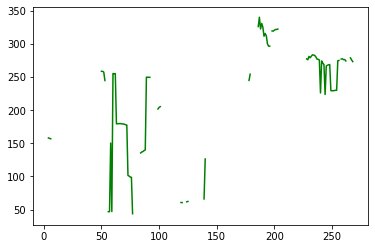

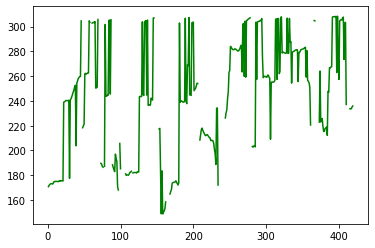

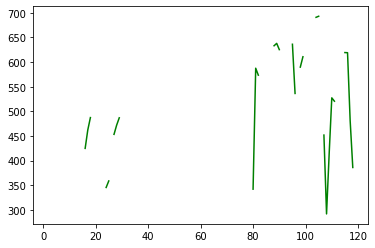

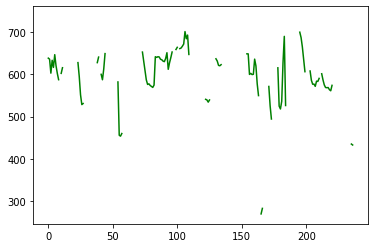

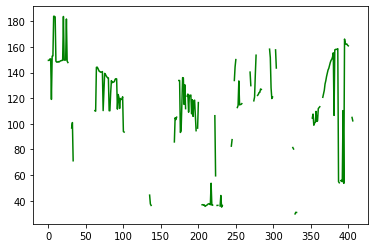

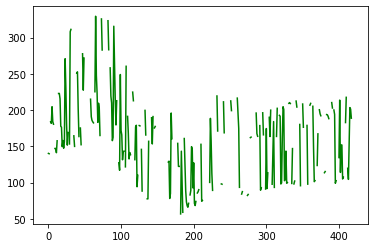

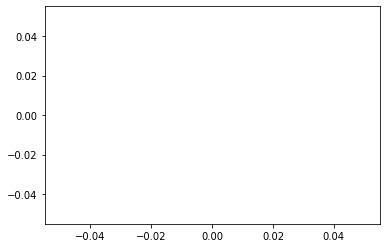

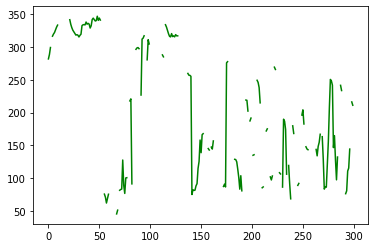

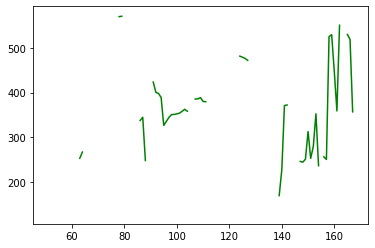

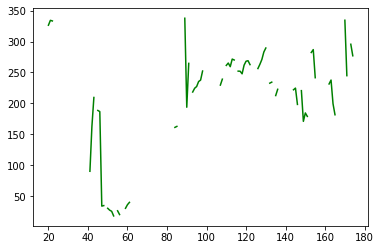

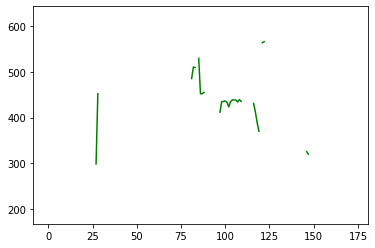

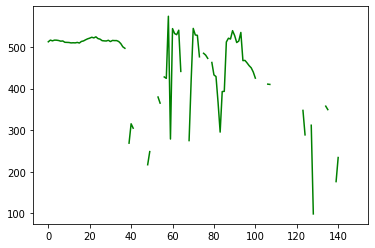

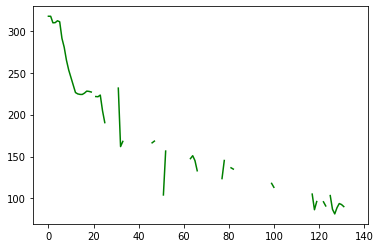

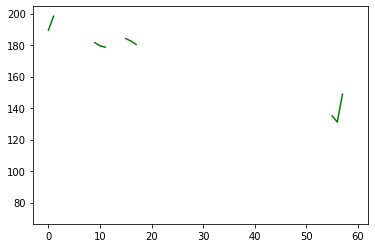

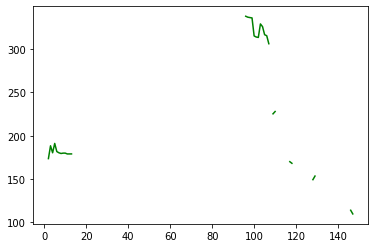

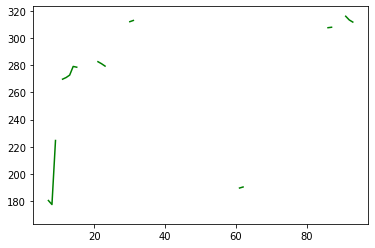

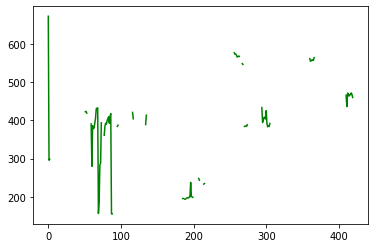

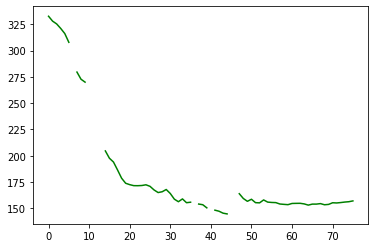

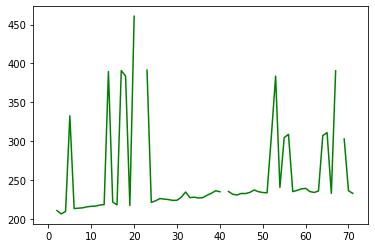

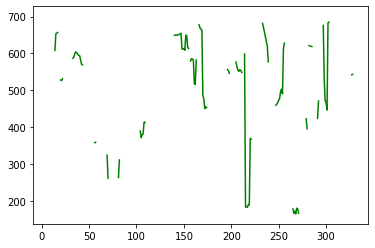

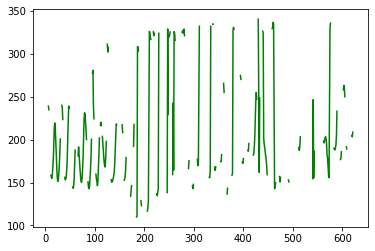

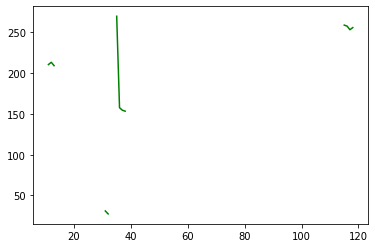

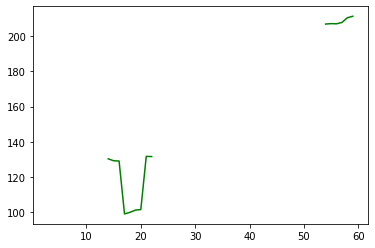

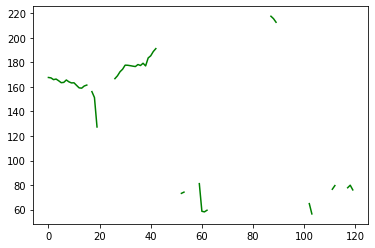

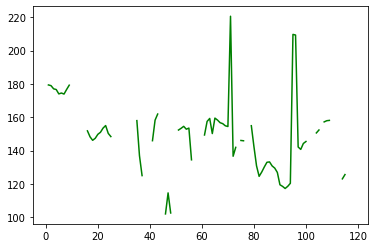

In [16]:
import matplotlib.pyplot as plt
import os 

# first all hand flapping videos 
for hand_flap_video in os.listdir("behavior_data/armflapping"):
    video = "behavior_data/armflapping/" + hand_flap_video
    cap = cv2.VideoCapture(video)
    
    hands = mp_hands.Hands(min_detection_confidence = 0.5, min_tracking_confidence = 0.5)
    
    all_YS = [] 
    
    while cap.isOpened():
        ret, image = cap.read() 
        if not ret:break 

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False 
        results = hands.process(image)

        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        height, width, _ = image.shape

        #check for hand results 
        y_s = []
        
        if results.multi_hand_landmarks:
            for hand_landmark in results.multi_hand_landmarks:
                for i in range(0, 21):
                    landmark = hand_landmark.landmark[i]
                    x = int(landmark.x * width)
                    y = int(landmark.y * height)
                    y_s.append(y)
        
        all_YS.append(np.mean(y_s))

    plt.plot(range(len(all_YS)), all_YS, color = "green")
    plt.show()

/Users/anish/Library/Python/3.8/lib/python/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/anish/Library/Python/3.8/lib/python/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


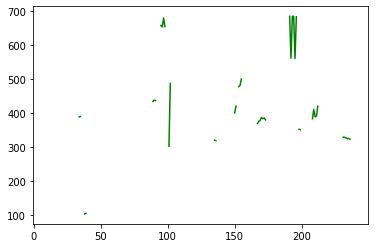

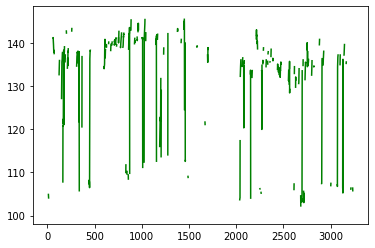

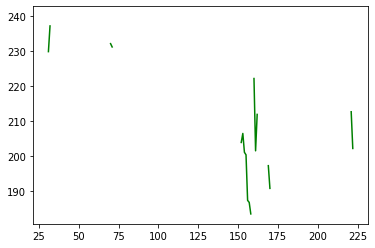

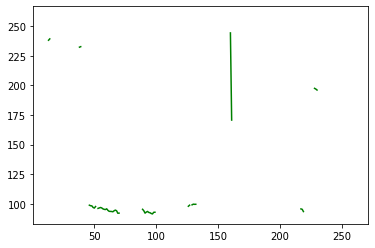

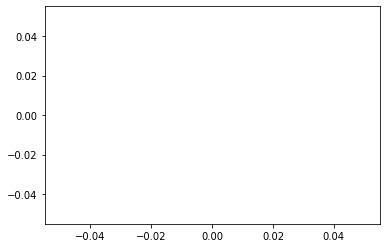

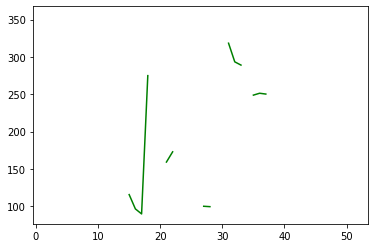

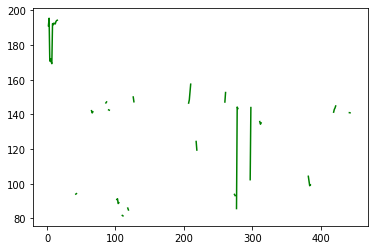

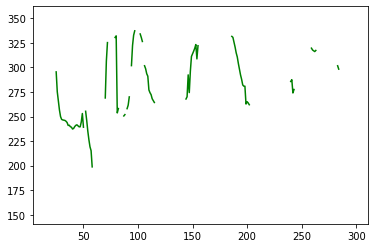

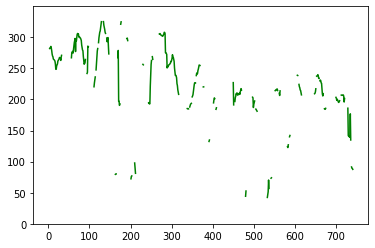

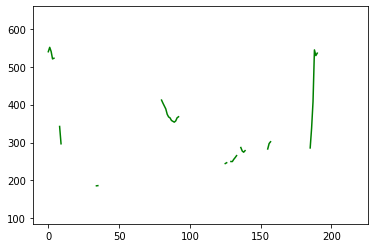

In [ ]:
# now for spinning 

import matplotlib.pyplot as plt
import os 

# first all hand flapping videos 
for hand_flap_video in os.listdir("behavior_data/spinning"):
    video = "behavior_data/spinning/" + hand_flap_video
    cap = cv2.VideoCapture(video)
    
    hands = mp_hands.Hands(min_detection_confidence = 0.5, min_tracking_confidence = 0.5)
    
    all_YS = [] 
    
    while cap.isOpened():
        ret, image = cap.read() 
        if not ret:break 

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False 
        results = hands.process(image)

        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        height, width, _ = image.shape

        #check for hand results 
        y_s = []
        
        if results.multi_hand_landmarks:
            for hand_landmark in results.multi_hand_landmarks:
                for i in range(0, 21):
                    landmark = hand_landmark.landmark[i]
                    x = int(landmark.x * width)
                    y = int(landmark.y * height)
                    y_s.append(y)
        
        all_YS.append(np.mean(y_s))

    plt.plot(range(len(all_YS)), all_YS, color = "green")
    plt.show()